# HCPREps generation
This notebook contains all the code used for the generation of HCPREps

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-loading" data-toc-modified-id="Data-loading-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data loading</a></span></li><li><span><a href="#KF19-remap-and-preprocessing" data-toc-modified-id="KF19-remap-and-preprocessing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>KF19 remap and preprocessing</a></span><ul class="toc-item"><li><span><a href="#Remap" data-toc-modified-id="Remap-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Remap</a></span></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Preprocessing</a></span></li><li><span><a href="#Remap-Analysis" data-toc-modified-id="Remap-Analysis-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Remap Analysis</a></span></li></ul></li><li><span><a href="#Overlap" data-toc-modified-id="Overlap-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Overlap</a></span><ul class="toc-item"><li><span><a href="#Overlap-Analysis" data-toc-modified-id="Overlap-Analysis-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Overlap Analysis</a></span></li></ul></li></ul></div>

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 50)
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

## Data loading

In [2]:
# SVM-MOCCA
mocca = pd.read_csv(
    'input_files/SVMMOCCA/SFile3_SVMMOCCA_PREPredictions.gff',
    index_col=False, header=None, sep = "\t")

mocca.columns = ["chr", "noth1", "noth2", "start", "stop", "score",
                 "strand", "noth3", "noth4"]

#Khabiri Fredolino 2019
kf19_raw = pd.read_csv(
    'input_files/KF19/chrfiltered_pres_flybase_v6.gff',
    index_col=False, skiprows=False,
                   header=0, sep = "\t")

## KF19 remap and preprocessing
### Remap
For the remap the following lines were executed from "HCPREps_generation/" obtaining kf19_remapped

### Preprocessing

In [3]:
# Filtering of unmapped scaffold and NANs, keeping just 2R/L, 3R/L, 4, X and Y
good_chr = kf19_raw["chr"].drop_duplicates()
good_chr = good_chr[good_chr.apply(lambda x: len(x) < 3)] # NANs and alternative scaffold lenght >= 3

kf19_unrev = kf19_raw.loc[kf19_raw["chr"].isin(good_chr),:].copy()

# Filtering intervals wich size was altered (insertions/deletions)
## Extract old coordinates from the info column
kf19_unrev.loc[:,"chr_old"] = [x.split(":")[0] 
                               for x in kf19_unrev["info"]]

kf19_unrev.loc[:,"start_old"] = [int(x.split(":")[1].split("..")[0])
                                 for x in kf19_unrev["info"]]

kf19_unrev.loc[:,"stop_old"] = [int(x.split(":")[1].split("..")[1])
                                for x in kf19_unrev["info"]]

## Filtering 
kf19 = kf19_unrev.loc[(kf19_unrev["stop"]-kf19_unrev["start"])
                      ==
                      (kf19_unrev["stop_old"]-kf19_unrev["start_old"])].copy()

# Exportation
kf19.drop(columns=["log10(size)", "chr_old", "start_old", "stop_old"],
          inplace= True, errors="ignore")

kf19.to_csv("output_files/processed_kf19.gff",index=None, sep="\t")

kf19

,chr,noth1,noth2,start,stop,score,noth3,info,PREname
0,2L,Unnamed,Unnamed,1.0,6100.0,0.925,.,2L:1..6100,PRE345
1,2L,Unnamed,Unnamed,10004351.0,10004900.0,0.865,.,2L:10004351..10004900,PRE11
2,2L,Unnamed,Unnamed,10025451.0,10026250.0,0.800,.,2L:10025451..10026250,PRE12
3,2L,Unnamed,Unnamed,10032451.0,10033500.0,0.870,.,2L:10032451..10033500,PRE13
4,2L,Unnamed,Unnamed,10037601.0,10037900.0,0.855,.,2L:10037601..10037900,PRE14
5,2L,Unnamed,Unnamed,10039101.0,10039650.0,0.840,.,2L:10039101..10039650,PRE15
6,2L,Unnamed,Unnamed,10054101.0,10054650.0,0.805,.,2L:10054101..10054650,PRE16
7,2L,Unnamed,Unnamed,10056701.0,10058100.0,0.805,.,2L:10056701..10058100,PRE17
8,2L,Unnamed,Unnamed,10076751.0,10077950.0,0.860,.,2L:10076751..10077950,PRE18
9,2L,Unnamed,Unnamed,10079951.0,10080700.0,0.830,.,2L:10079951..10080700,PRE19


### Remap Analysis

dm6 kf19 keep 89.55% of the original predictions


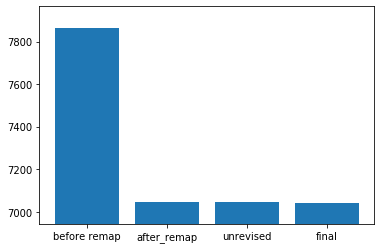

In [4]:
before_remap = 7865
after_remap = kf19_raw.shape[0]
unrevised = kf19_unrev.shape[0]
final = kf19.shape[0]
n_predictions = [before_remap,after_remap, unrevised, final]


plt.bar(["before remap","after_remap", "unrevised", "final" ],n_predictions)
plt.ylim(min(n_predictions)-100, max(n_predictions)+100)
print("dm6 kf19 keep %.2f%% of the original predictions"
      %(final*100/before_remap))

## Overlap

Two intersects as the non coordinate columns (scores/IDs etc) are only kept for the -a document of each intercept

In [5]:
!bedtools intersect -a input_files/SVMMOCCA/SFile3_SVMMOCCA_PREPredictions.gff \
                    -b output_files/processed_kf19.gff \
                    > output_files/intersects/intersect_mocca.gff

!bedtools intersect -b input_files/SVMMOCCA/SFile3_SVMMOCCA_PREPredictions.gff \
                    -a output_files/processed_kf19.gff \
                    > output_files/intersects/intersect_kf19.gff

In [6]:
# Overlap postprocessing
## Load intersect and put headers
intersect_mocca = pd.read_csv("output_files/intersects/intersect_mocca.gff",
                              index_col=False, header=None, sep = "\t")

intersect_mocca.columns = mocca.columns


intersect_kf19 = pd.read_csv("output_files/intersects/intersect_kf19.gff",
                             index_col=False, header=None, sep = "\t")

intersect_kf19.columns = kf19.columns


## Combination of intersects
intersect_mocca.sort_values(by= ["chr", "start"],inplace=True)
intersect_kf19.sort_values(by= ["chr", "start"],inplace=True)

#np.all(intersect_mocca[["chr", "start", "stop"]].values == intersect_kf19[["chr", "start", "stop"]].values) # intervalls are identically ordered
HCPREps = intersect_mocca.copy()
HCPREps.rename(columns={"score": "score_mocca"}, inplace= True)
HCPREps["score_kf19"] = intersect_kf19["score"]

## Export
HCPREps.to_csv("output_files/HCPREps.gff", sep = "\t",index= False)

HCPREps

,chr,noth1,noth2,start,stop,score_mocca,strand,noth3,noth4,score_kf19
0,2L,Unnamed,Unnamed,160501,161550,41.071573,+,.,1,0.855
1,2L,Unnamed,Unnamed,161651,162150,41.071573,+,.,1,0.840
2,2L,Unnamed,Unnamed,220401,220950,54.602111,+,.,1,0.860
3,2L,Unnamed,Unnamed,248501,249700,57.687819,+,.,1,0.830
4,2L,Unnamed,Unnamed,250551,251100,57.687819,+,.,1,0.810
5,2L,Unnamed,Unnamed,302001,302850,41.953060,+,.,1,0.920
6,2L,Unnamed,Unnamed,376051,376400,19.685766,+,.,1,0.845
7,2L,Unnamed,Unnamed,377551,378250,19.685766,+,.,1,0.930
8,2L,Unnamed,Unnamed,479651,480400,85.907493,+,.,1,0.850
9,2L,Unnamed,Unnamed,487451,488100,85.907493,+,.,1,0.835


### Overlap Analysis

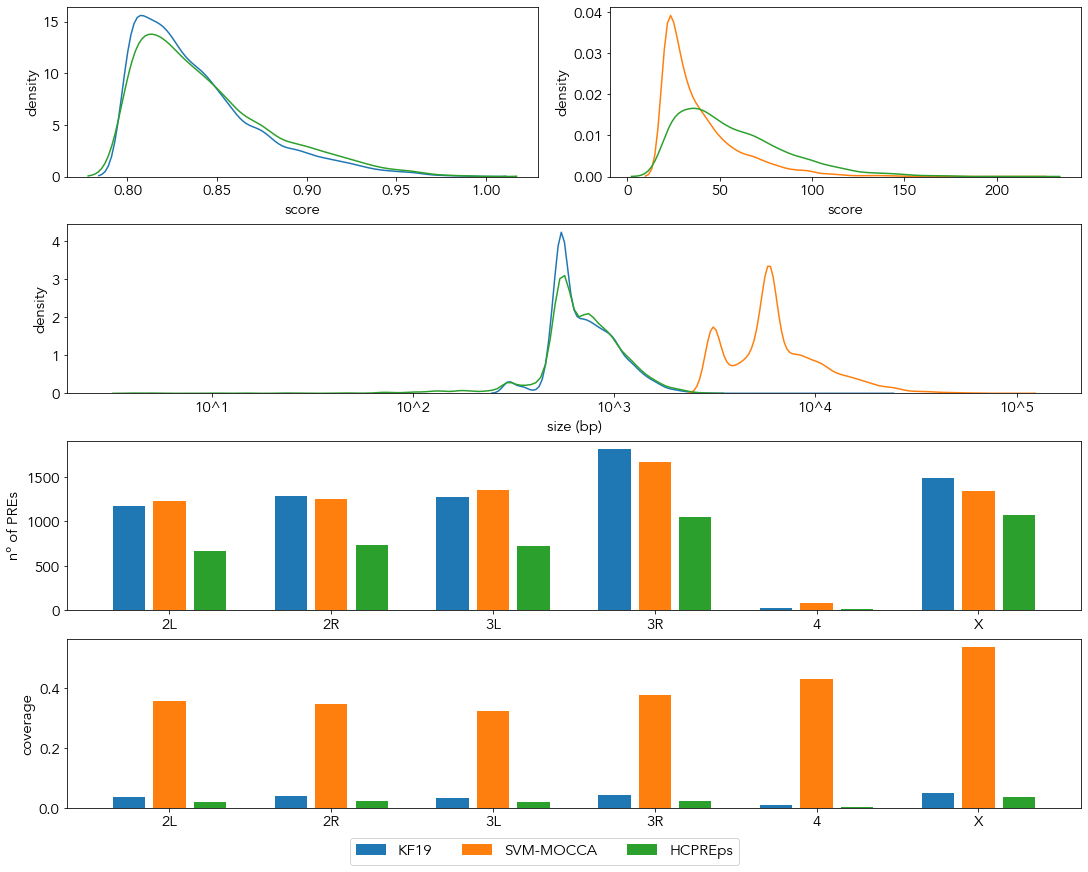

In [7]:
# Calculations for nº and coverage of PREs
## Chromosome scaffold information obtained from https://www.ncbi.nlm.nih.gov/assembly/GCF_000001215.4/#/st (Assembled molecule) 
chromosome_info = pd.DataFrame()
chromosome_info.loc["totalbp","2L"] = 23513712
chromosome_info.loc["totalbp","2R"] = 25286936
chromosome_info.loc["totalbp","3L"] = 28110227
chromosome_info.loc["totalbp","3R"] = 32079331
chromosome_info.loc["totalbp","4"] = 1348131
chromosome_info.loc["totalbp","X"] = 23542271
#chromosome_info.loc["totalbp","Y"] = 3667352

## Calculation
for n in range(len(chromosome_info.columns)):
    ch = chromosome_info.columns[n]
    subset_kf19 = kf19.loc[kf19["chr"] == ch,:]
    subset_mocca = mocca.loc[mocca["chr"] == ch,:]
    subset_HCPREps = HCPREps.loc[HCPREps["chr"] == ch,:]
    
    chromosome_info.loc["kf19_count", ch] = subset_kf19.shape[0]
    chromosome_info.loc["mocca_count", ch] = subset_mocca.shape[0]
    chromosome_info.loc["HCPREps_count", ch] = subset_HCPREps.shape[0]
    
    chromosome_info.loc["kf19_cov", ch] = sum(subset_kf19["stop"] - subset_kf19["start"])
    chromosome_info.loc["mocca_cov", ch] = sum(subset_mocca["stop"] - subset_mocca["start"])
    chromosome_info.loc["HCPREps_cov", ch] = sum(subset_HCPREps["stop"] - subset_HCPREps["start"])## Count per Chr

# Plots
## set the grid plot
mpl.rcParams['font.family'] = 'Avenir'
plt.rcParams.update({'font.size': 15})
fig8 = plt.figure(constrained_layout=True, figsize=(15, 12))
gs1 = fig8.add_gridspec(nrows=25, ncols=2, left=0.05, right=0.48, wspace=0.05)


## Score KF19
f8_ax1 = fig8.add_subplot(gs1[0:6, 0])
sns.kdeplot(kf19["score"], label="KF19", shade= False, alpha = 1,color= "tab:blue", ax=f8_ax1)
sns.kdeplot(HCPREps["score_kf19"], label="HCPREps", shade= False, alpha = 1,color= "tab:green", ax=f8_ax1)
f8_ax1.set_xlabel("score")
f8_ax1.set_ylabel("density")
f8_ax1.legend_.remove()

## Score SVM-MOCCA
f8_ax2 = fig8.add_subplot(gs1[0:6, 1])
sns.kdeplot(mocca["score"], label="SVM-MOCCA", shade= False, alpha = 1,color= "tab:orange", ax=f8_ax2)
sns.kdeplot(HCPREps["score_mocca"], label="HCPREps", shade= False, alpha = 1,color= "tab:green", ax=f8_ax2)
f8_ax2.set_xlabel("score")
f8_ax2.set_ylabel("density")
f8_ax2.legend_.remove()

## Size
f8_ax3 = fig8.add_subplot(gs1[6:12, :])
sns.kdeplot(np.log10(kf19["stop"]-kf19["start"]), label="KF19",
            shade= False, alpha = 1,color= "tab:blue", ax = f8_ax3)

sns.kdeplot(np.log10(mocca["stop"]-mocca["start"]), label="SVM-MOCCA",
            shade= False, alpha = 1,color= "tab:orange", ax = f8_ax3)

sns.kdeplot(np.log10(HCPREps["stop"]-HCPREps["start"]), label="HCPREps",
            shade= False, alpha = 1,color= "tab:green", ax = f8_ax3)


f8_ax3.legend_.remove()
f8_ax3.set_xticklabels(("10^%i"%(x)) for x in f8_ax3.get_xticks())
f8_ax3.set_xlabel("size (bp)")
f8_ax3.set_ylabel("density")

## Size per chr
f8_ax4 = fig8.add_subplot(gs1[12:18, :])
f8_ax4.bar([x for x in range(0, chromosome_info.shape[1]*4, 4)],
        chromosome_info.loc["kf19_count",:],
       label ="KF19")

f8_ax4.bar([x for x in range(1, chromosome_info.shape[1]*4, 4)],
        chromosome_info.loc["mocca_count",:],
        label = "SVM-MOCCA")

f8_ax4.bar([x for x in range(2, chromosome_info.shape[1]*4, 4)],
        chromosome_info.loc["HCPREps_count",:],
        label = "HCPREps")

f8_ax4.set_xticks([x + 1 for x in range(0, chromosome_info.shape[1]*4, 4)])
f8_ax4.set_xticklabels(chromosome_info.columns)
plt.ylabel("nº of PREs", fontweight="bold")

## Coverage per chr
f8_ax5 = fig8.add_subplot(gs1[18:24, :])
f8_ax5.bar([x for x in range(0, chromosome_info.shape[1]*4, 4)],
        chromosome_info.loc["kf19_cov",:]/chromosome_info.loc["totalbp",:],
       label ="KF19")

f8_ax5.bar([x for x in range(1, chromosome_info.shape[1]*4, 4)],
        chromosome_info.loc["mocca_cov",:]/chromosome_info.loc["totalbp",:],
        label = "SVM-MOCCA")

f8_ax5.bar([x for x in range(2, chromosome_info.shape[1]*4, 4)],
        chromosome_info.loc["HCPREps_cov",:]/chromosome_info.loc["totalbp",:],
        label = "HCPREps")


f8_ax5.set_xticks([x + 1 for x in range(0, chromosome_info.shape[1]*4, 4)])
f8_ax5.set_xticklabels(chromosome_info.columns)

f8_ax5.set_ylabel("coverage", fontweight="bold")


handles, labels = f8_ax5.get_legend_handles_labels()
fig8.legend(handles, labels, loc='lower center', ncol=3)

plt.savefig("plots/distributions.png", dpi = 500, transparent = True)
plt.show()